In [13]:
import pandas as pd
import numpy as np
import pylab as pl
from pylab import*
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.datasets import make_moons, make_circles, make_classification

In [2]:
def linear(x1, x2):
    return np.dot(x1, x2)

def polynomial(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

In [3]:
from array import array
from cvxopt import matrix,solvers

In [4]:
# Gram matrix
def gram(X, kernel = linear):

    (m,n) = np.shape(X)
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            if kernel is polynomial:
                K[i,j] = polynomial(X[i], X[j])
            elif kernel is gaussian: 
                K[i,j] = gaussian(X[i], X[j])
            else:
                K[i,j] = linear(X[i],X[j])
                
    return K


def k_fit(X,y,c=None, kernel = linear):
    (m,n) = np.shape(X)
    
    K = gram(X, kernel)

    if c is None:
        G = matrix(np.diag(np.ones(m) * -1))
        h = matrix(np.zeros(m))
    else:

        G0 = np.identity(m)
        G = matrix(np.append(-G0, G0,axis=0))
        
        h0 = np.zeros(m)
        h1 = np.empty(m)
        h1.fill(c)
        h = matrix(np.append(h0,h1))
        
    q = matrix(-np.ones(m))
    P = matrix(np.outer(y, y) * K)
    P = matrix(P)
    A = matrix(y, (1,m),tc='d')
    b = matrix(0.0)


    sol=solvers.qp(P, q, G, h, A, b)
    a = np.ravel(sol['x'])
    
    
    # compute weight and bias
    
    idxa = a>1e-5
    idx = np.arange(len(a))[idxa]
    sva = a[idxa]
    svx = X[idxa]
    svy = y[idxa]
    nsv = len(sva)
    print "%d support vectors out of %d points" %(nsv,len(a))

    if kernel is linear:
        w = np.empty(shape(X)[1])
        w = (sva*svy).dot(svx)
    else: 
        w = None
        
    b = 0
    for n in range(0, nsv):
        b += svy[n]
        b -= np.sum(sva*svy* K[idx[n],idxa])
    b /= nsv
    
#             self.b = 0
#         for n in range(len(self.a)):
#             self.b += self.sv_y[n]
#             self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
#         self.b /= len(self.a)
    
    
    return (sva,svx,svy,w,b)


In [5]:
def k_predict(X_test, sva, svx, svy, w, b, kernel):
    m = len(X_test)
    if w is not None:
        return b + dot(X_test,w[None].T)
    else:
        y_predict = np.zeros(m)
        for i in range(0, m):
            s = 0
            for a, sv_y, sv in zip(sva, svy, svx):
#                 print 'x[i]', X_test[i]
                if kernel == linear:
                    k = linear(X_test[i], sv)
                elif kernel == gaussian:
                    k = gaussian(X_test[i], sv)
                else:
                    k = polynomial(X_test[i], sv)
                s += a * sv_y * k
                y_predict[i] = s
        return y_predict + b
    

In [6]:
# K fold
def k_fold(size,k, shuffle = False):
    index = np.arange(0,size)
    if shuffle:
        np.random.shuffle(index)
    index = np.reshape(index, (k,size/k))
#     print index
    test = []
    train = []
    cursor = 0
    for i in range(0,k):
        test.append(index[i])
        temp = np.delete(index,i,0)
        train.append(temp.flatten())
    return test, train

In [82]:
def Kernel_SVM(X,y, c = None, kernel = linear):
    
    test, train = k_fold(len(y),5)
    X_test = X[test[0]]
    X_train = X[train[0]]
    y_test = y[test[0]]
    y_train = y[train[0]]
    
    K = gram(X_train, kernel)
    t = k_fit(X_train,y_train,c, kernel)
    sva = t[0]
    svx = t[1]
    svy = t[2]
    w = t[3]
    b = t[4]
    
    predict = k_predict(X_test, sva, svx, svy, w, b, kernel)
    

    pre = np.sign(predict)
    
    pre1 = pre.flatten()
    y_test1 = y_test.flatten()
    correct = np.sum(pre.flatten() == y_test.flatten())
    
    print "%d out of %d predictions correct" % (correct, len(y_test))
    print 'Accurcy of SVM is ',correct/float(len(y_test))
    
    plt.title("Dataset")
    plt.scatter(X_train[:,0], X_train[:,1], s=30, c=y_train,cmap=plt.cm.Spectral)
    plt.scatter(svx[:,0], svx[:,1], s = 40, c = "g")
    X1, X2 = np.meshgrid(np.linspace(-4,5,50), np.linspace(-4,5,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = k_predict(X, sva, svx, svy, w, b, kernel).reshape(X1.shape)
    pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

    pl.axis("tight")
    return None




# Results and explanation starts from here

## 1. Generate a small dataset of 2D feature vectors of two classes such that the classes are linearly separable. Similarly, generate an additional set with examples that are not separable.

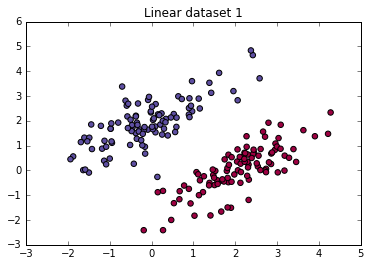

In [8]:
# Generate a linear dataset and plot it
def lineardata(datasize = 200):
    # generate training data in the 2-d case
    size = datasize/2
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.8, 0.6], [0.6, 0.8]])
    X1 = np.random.multivariate_normal(mean1, cov, size)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, size)
    y2 = np.ones(len(X2)) * -1
    X = np.append(X1, X2,axis = 0)
    y = np.append(y1,y2)
    return X,y




X,y = lineardata()
plt.title("Linear dataset 1")
plt.scatter(X[:,0], X[:,1], s=30, c=y, cmap=plt.cm.Spectral)


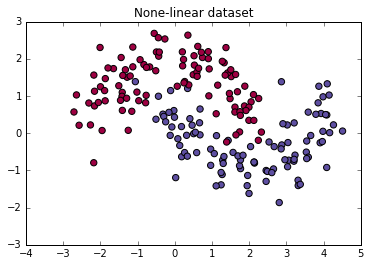

In [9]:
# Generate a non-linear dataset and plot it

def nonlineardata(size = 200):
    np.random.seed(0)
    X, y = sklearn.datasets.make_moons(size, noise=0.2)
    y[y == 0] = -1
    return X*2,y

X_nl, y_nl = nonlineardata()

plt.title("None-linear dataset")
plt.scatter(X_nl[:,0], X_nl[:,1], s=40, c=y_nl, cmap=plt.cm.Spectral)

## Two additional dataset for later use

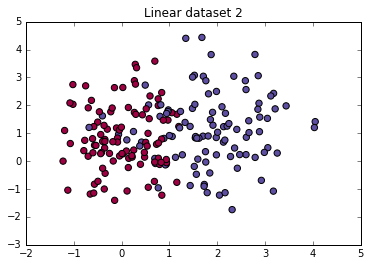

In [104]:
# Generate anonther Linear dataset and plot it
def lineardata2(size = 200):
    X, y = make_classification(size,n_features=2, n_redundant=0, n_informative=1, random_state=2, n_clusters_per_class=1)
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    y[y == 0] = -1
    return X,y

X2,y2 = lineardata2()
plt.title("Linear dataset 2")
plt.scatter(X2[:,0], X2[:,1], s=40, c=y2, cmap=plt.cm.Spectral)

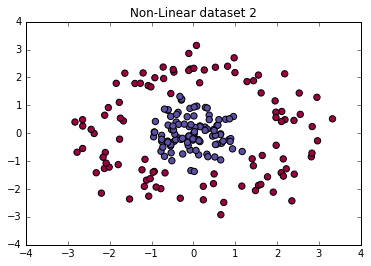

In [118]:
# Generate anonter Non-linear dataset and plot it
def nonlineardata2(size = 200):
    X, y = make_circles(size, noise=0.2, factor=0.2, random_state=1)
    y[y == 0] = -1
    return X*2.3,y

X2_nl, y2_nl = nonlineardata2()
plt.title("Non-Linear dataset 2")
plt.scatter(X2_nl[:,0], X2_nl[:,1], s=40, c=y2_nl, cmap=plt.cm.Spectral)

## 2. Implement a linear SVM algorithm with hard margins and apply it to the separable dataset you generated. Plot the data points and mark the support vectors you identified. Apply the algorithm you implemented to the non-separable dataset and observe the results. Make sure to normalize the data if necessary (in this and subsequent algorithms you implement)¶

In [15]:
from array import array
from cvxopt import matrix,solvers

Linear dataset using hard margins: 
     pcost       dcost       gap    pres   dres
 0: -1.3588e+01 -2.9865e+01  5e+02  2e+01  2e+00
 1: -1.9003e+01 -2.5169e+01  3e+02  1e+01  1e+00
 2: -3.8010e+01 -2.9663e+01  2e+02  6e+00  6e-01
 3: -8.4612e+01 -5.5143e+01  2e+02  5e+00  6e-01
 4: -3.0565e+01 -1.6378e+01  5e+01  1e+00  1e-01
 5: -9.4373e+00 -1.1808e+01  2e+00  2e-15  7e-15
 6: -1.0695e+01 -1.0931e+01  2e-01  4e-15  5e-15
 7: -1.0876e+01 -1.0878e+01  2e-03  3e-15  4e-15
 8: -1.0878e+01 -1.0878e+01  2e-05  3e-15  5e-15
 9: -1.0878e+01 -1.0878e+01  2e-07  7e-16  6e-15
Optimal solution found.
3 support vectors out of 160 points
40 out of 40 predictions correct
Accurcy of SVM is  1.0


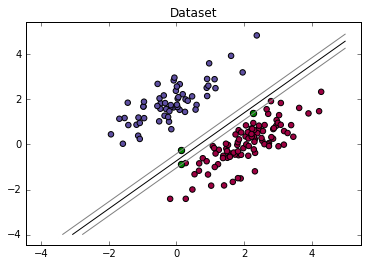

In [83]:

print "Linear dataset using hard margins: "
Kernel_SVM(X,y)

In linearly separable data, The accurcy of SVM of hard Margine works well.

Non-Linear dataset using hard margins: 
     pcost       dcost       gap    pres   dres
 0: -6.2082e+01 -1.7655e+02  7e+02  2e+01  3e+00
 1: -2.4715e+02 -5.0497e+02  6e+02  1e+01  2e+00
 2: -1.0888e+03 -1.4693e+03  4e+02  1e+01  1e+00
 3: -2.6478e+03 -3.2418e+03  6e+02  9e+00  1e+00
 4: -9.8628e+03 -1.1002e+04  1e+03  8e+00  1e+00
 5: -8.3227e+04 -8.5439e+04  2e+03  7e+00  1e+00
 6: -1.6494e+06 -1.6719e+06  2e+04  7e+00  1e+00
 7: -1.0235e+08 -1.0260e+08  2e+05  7e+00  1e+00
 8: -3.8835e+10 -3.8842e+10  8e+06  7e+00  1e+00
 9: -5.3094e+10 -5.3105e+10  1e+07  7e+00  1e+00
10: -5.6323e+10 -5.6334e+10  1e+07  7e+00  1e+00
11: -2.6109e+11 -2.6114e+11  5e+07  7e+00  1e+00
12: -4.9295e+11 -4.9305e+11  1e+08  7e+00  1e+00
Terminated (singular KKT matrix).
160 support vectors out of 160 points
18 out of 40 predictions correct
Accurcy of SVM is  0.45


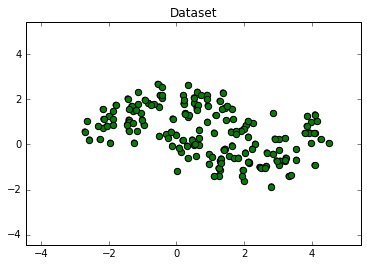

In [84]:

print "Non-Linear dataset using hard margins: "
Kernel_SVM(X_nl,y_nl,None,linear)

#### In non-linearly separable data, The accurcy of SVM of hard Margine is only 0.45.  
#### In train dataset, it considered all data as support vector.  

### This means in non-linearly separable dataset, hard margine of linear SVM doesn't work well.

## 4. Implement a linear SVM algorithm with soft margins and apply it to the datasets you generated. Plot the data points and mark the support vectors you identified.

Linear dataset uing soft margins: 
     pcost       dcost       gap    pres   dres
 0: -7.5642e+00 -2.5551e+01  8e+02  2e+01  3e-15
 1: -1.4680e+00 -2.3009e+01  5e+01  8e-01  3e-15
 2: -4.3969e-01 -5.8137e+00  6e+00  2e-02  2e-15
 3: -6.7526e-01 -1.7864e+00  1e+00  3e-03  9e-16
 4: -8.0480e-01 -1.3075e+00  5e-01  1e-03  8e-16
 5: -8.6581e-01 -1.1448e+00  3e-01  4e-04  9e-16
 6: -9.3118e-01 -9.8952e-01  6e-02  5e-05  1e-15
 7: -9.4919e-01 -9.5879e-01  1e-02  8e-06  9e-16
 8: -9.5227e-01 -9.5411e-01  2e-03  1e-06  9e-16
 9: -9.5297e-01 -9.5301e-01  4e-05  9e-09  1e-15
10: -9.5299e-01 -9.5299e-01  4e-07  9e-11  1e-15
Optimal solution found.
17 support vectors out of 160 points
40 out of 40 predictions correct
Accurcy of SVM is  1.0


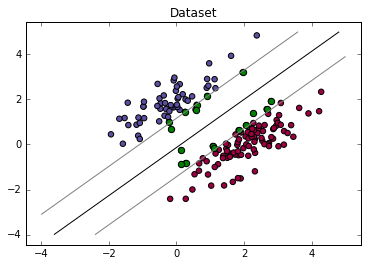

In [124]:
print "Linear dataset uing soft margins: "
Kernel_SVM(X,y,0.1)

#### Apply softemargins on the same linear-separable dataset, the margin is bigger than hard margin.

Non-Linear dataset using soft margins: 
     pcost       dcost       gap    pres   dres
 0: -3.4217e+01 -3.4157e+01  1e+03  3e+01  3e-15
 1: -5.5039e+00 -3.1974e+01  6e+01  8e-01  3e-15
 2: -4.1668e+00 -1.1741e+01  8e+00  2e-16  1e-15
 3: -4.9450e+00 -6.3450e+00  1e+00  2e-16  9e-16
 4: -5.2924e+00 -5.7254e+00  4e-01  5e-16  1e-15
 5: -5.3900e+00 -5.5695e+00  2e-01  2e-16  1e-15
 6: -5.4480e+00 -5.4775e+00  3e-02  2e-16  1e-15
 7: -5.4589e+00 -5.4628e+00  4e-03  2e-16  1e-15
 8: -5.4606e+00 -5.4606e+00  5e-05  2e-16  1e-15
 9: -5.4606e+00 -5.4606e+00  5e-07  2e-16  1e-15
Optimal solution found.
61 support vectors out of 160 points
30 out of 40 predictions correct
Accurcy of SVM is  0.75


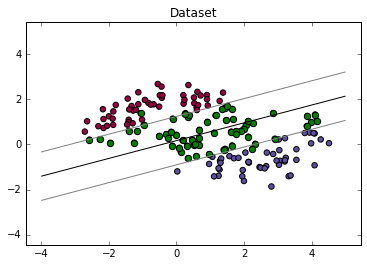

In [125]:
print "Non-Linear dataset using soft margins: "
Kernel_SVM(X_nl,y_nl, 0.1)

#### After several try to find the best C, I found that when C = 0.1, the accuracy is best, and with soft margine, linear SVM works a little bit better than hard margin on non-seperable dataset, even the accurcy is still unideality

## 5. Implement a kernel-based SVM algorithm using a polynomial and Gaussian kernel functions. Apply your implementation to the datasets you generated. Plot the support vectors you obtain. 

Linear dataset using polynomial kernel 
     pcost       dcost       gap    pres   dres
 0: -2.3062e+00 -2.4955e+01  8e+02  2e+01  1e-13
 1: -5.0535e-01 -2.2252e+01  3e+01  4e-01  9e-14
 2: -3.6756e-01 -8.2390e+00  1e+01  1e-01  4e-14
 3: -3.4985e-01 -3.2901e+00  4e+00  3e-02  2e-14
 4: -3.3454e-01 -1.1087e+00  1e+00  8e-03  7e-15
 5: -3.3547e-01 -5.7682e-01  3e-01  2e-03  3e-15
 6: -3.5167e-01 -4.1598e-01  8e-02  4e-04  2e-15
 7: -3.5423e-01 -3.7352e-01  2e-02  4e-05  4e-15
 8: -3.6091e-01 -3.6150e-01  6e-04  7e-07  2e-15
 9: -3.6115e-01 -3.6116e-01  8e-06  9e-09  2e-15
10: -3.6115e-01 -3.6115e-01  9e-08  9e-11  3e-15
Optimal solution found.
8 support vectors out of 160 points
40 out of 40 predictions correct
accurcy of SVM is  1.0


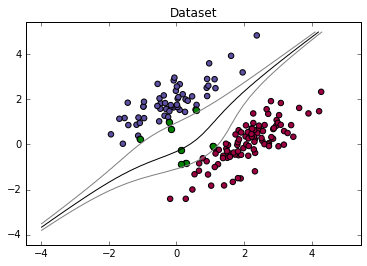

In [20]:
# X,y = lineardata()
print "Linear dataset using polynomial kernel "
Kernel_SVM(X,y,0.1, polynomial)


Linear dataset using Gaussian kernel 
     pcost       dcost       gap    pres   dres
 0:  3.5956e+02 -6.6801e+03  1e+04  4e-01  2e-14
 1:  3.3374e+02 -7.7132e+02  1e+03  2e-03  2e-14
 2:  1.9246e+01 -1.1821e+02  1e+02  2e-15  2e-14
 3: -1.4947e+01 -6.5135e+01  5e+01  3e-15  1e-14
 4: -2.4814e+01 -5.3981e+01  3e+01  5e-16  9e-15
 5: -2.6230e+01 -5.3437e+01  3e+01  2e-14  8e-15
 6: -3.2469e+01 -5.2622e+01  2e+01  1e-14  8e-15
 7: -3.5181e+01 -5.0825e+01  2e+01  3e-14  8e-15
 8: -4.1016e+01 -4.4997e+01  4e+00  1e-14  1e-14
 9: -4.2474e+01 -4.3009e+01  5e-01  2e-15  1e-14
10: -4.2696e+01 -4.2705e+01  9e-03  2e-14  1e-14
11: -4.2700e+01 -4.2700e+01  9e-05  1e-14  1e-14
12: -4.2700e+01 -4.2700e+01  9e-07  8e-15  1e-14
Optimal solution found.
8 support vectors out of 160 points
40 out of 40 predictions correct
Accurcy of SVM is  1.0


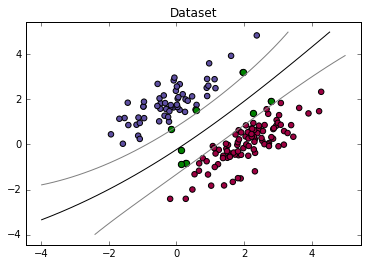

In [129]:
print "Linear dataset using Gaussian kernel "
Kernel_SVM(X,y,10, gaussian)

#### After several tries, I found the best value of C is 10. The value of C is not very sensitive for linear sperate dataset, but if C<1.0, the SVM function may overfitting.


Non-Linear dataset using polynomial kernel: 
     pcost       dcost       gap    pres   dres
 0: -6.2154e+02 -1.9872e+05  4e+05  5e-01  2e-11
 1: -3.2136e+02 -7.9532e+04  1e+05  1e-01  3e-11
 2: -1.9041e+02 -4.3413e+04  7e+04  7e-02  2e-11
 3:  4.8362e+01 -1.6378e+04  3e+04  2e-02  9e-12
 4:  1.4653e+02 -5.5404e+03  8e+03  6e-03  5e-12
 5:  6.4230e+01 -2.2501e+03  3e+03  1e-03  2e-12
 6: -1.0995e+02 -9.9371e+02  1e+03  4e-04  2e-12
 7: -1.9576e+02 -6.8437e+02  5e+02  2e-04  3e-12
 8: -2.5656e+02 -5.0442e+02  3e+02  5e-05  3e-12
 9: -2.8865e+02 -4.2610e+02  1e+02  1e-05  3e-12
10: -3.1556e+02 -3.6281e+02  5e+01  4e-06  3e-12
11: -3.2464e+02 -3.4417e+02  2e+01  5e-15  5e-12
12: -3.3279e+02 -3.3356e+02  8e-01  3e-14  5e-12
13: -3.3311e+02 -3.3312e+02  8e-03  7e-14  5e-12
14: -3.3311e+02 -3.3311e+02  8e-05  9e-16  7e-12
Optimal solution found.
13 support vectors out of 160 points
37 out of 40 predictions correct
Accurcy of SVM is  0.925


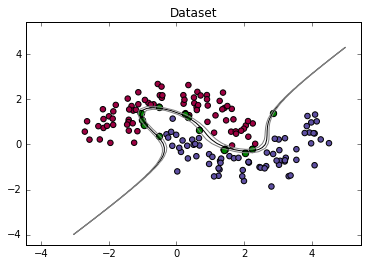

In [133]:
print "Non-Linear dataset using polynomial kernel: "
Kernel_SVM(X_nl,y_nl,50,polynomial)

#### After several tries, I found the best value of C is 10. The value of C is not very sensitive for linear sperate dataset, but if C is too large, the margins become very narrow, the SVM function may overfitting.

Non-Linear dataset using Gaussian kernel: 
     pcost       dcost       gap    pres   dres
 0:  2.8644e+04 -6.1004e+05  9e+05  2e-01  8e-14
 1:  1.0300e+04 -7.5233e+04  9e+04  1e-02  9e-14
 2: -5.1904e+02 -2.0976e+04  2e+04  2e-03  1e-13
 3: -2.4141e+03 -6.9712e+03  5e+03  2e-04  1e-13
 4: -2.7988e+03 -5.9172e+03  3e+03  9e-05  1e-13
 5: -3.0119e+03 -5.4030e+03  2e+03  6e-05  1e-13
 6: -3.2263e+03 -4.7828e+03  2e+03  4e-05  1e-13
 7: -3.3872e+03 -4.4225e+03  1e+03  2e-05  2e-13
 8: -3.4533e+03 -4.1965e+03  7e+02  1e-05  2e-13
 9: -3.5530e+03 -3.9056e+03  4e+02  2e-06  2e-13
10: -3.6214e+03 -3.7897e+03  2e+02  6e-07  2e-13
11: -3.6669e+03 -3.7137e+03  5e+01  2e-07  2e-13
12: -3.6831e+03 -3.6889e+03  6e+00  1e-08  2e-13
13: -3.6856e+03 -3.6857e+03  1e-01  1e-10  3e-13
14: -3.6856e+03 -3.6856e+03  1e-03  1e-12  2e-13
Optimal solution found.
64 support vectors out of 160 points
37 out of 40 predictions correct
Accurcy of SVM is  0.925


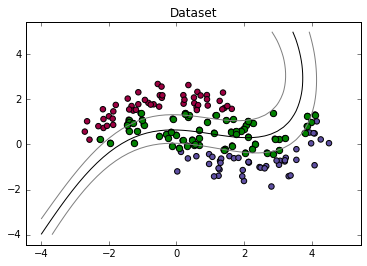

In [137]:
print "Non-Linear dataset using Gaussian kernel: "
Kernel_SVM(X_nl,y_nl,100, gaussian)

#### After several tries, I found the best value of C is 10. If the value of C is getting larger, it may cause overfitting, otherwise if the value of C is getting too small, the margine become very large, it may cause underfitting.

## Test the algorithm on two additional external datasets and report performance. Test and explain the effect of modifying different parameters of the algorithm.

Another linear dataset using polynomial kernel 
     pcost       dcost       gap    pres   dres
 0: -3.5566e+01 -7.0456e+01  1e+03  1e+01  5e-13
 1: -9.3924e+00 -6.1805e+01  1e+02  5e-01  4e-13
 2: -8.3361e+00 -3.1520e+01  3e+01  2e-01  2e-13
 3: -8.3906e+00 -1.8908e+01  1e+01  7e-02  9e-14
 4: -8.3742e+00 -1.4716e+01  8e+00  2e-02  4e-14
 5: -8.5806e+00 -1.0130e+01  2e+00  5e-03  7e-14
 6: -8.6501e+00 -8.9769e+00  4e-01  9e-04  7e-14
 7: -8.6472e+00 -8.9590e+00  4e-01  7e-04  5e-14
 8: -8.6980e+00 -8.7795e+00  9e-02  1e-04  6e-14
 9: -8.7072e+00 -8.7437e+00  4e-02  2e-05  8e-14
10: -8.7200e+00 -8.7255e+00  6e-03  2e-06  8e-14
11: -8.7223e+00 -8.7224e+00  7e-05  2e-08  7e-14
12: -8.7223e+00 -8.7223e+00  7e-07  2e-10  1e-13
Optimal solution found.
49 support vectors out of 160 points
37 out of 40 predictions correct
Accurcy of SVM is  0.925


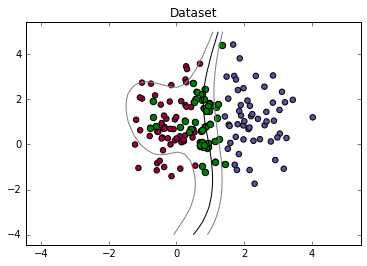

In [143]:
# X,y = lineardata()
print "Another linear dataset using polynomial kernel "
Kernel_SVM(X2,y2,0.2, polynomial)


Another non-Linear dataset using polynomial kernel: 
     pcost       dcost       gap    pres   dres
 0: -1.8609e+01 -2.8445e+01  9e+02  2e+01  1e-13
 1: -3.5670e+00 -2.5994e+01  8e+01  2e+00  2e-13
 2: -1.7873e+00 -1.3451e+01  2e+01  3e-01  3e-14
 3: -1.1596e+00 -5.9430e+00  8e+00  1e-01  1e-14
 4: -8.6292e-01 -3.4821e+00  4e+00  5e-02  8e-15
 5: -7.0952e-01 -1.5297e+00  1e+00  1e-02  5e-15
 6: -7.3922e-01 -1.0287e+00  4e-01  3e-03  4e-15
 7: -7.7131e-01 -8.5671e-01  9e-02  2e-16  4e-15
 8: -8.0257e-01 -8.1364e-01  1e-02  2e-16  4e-15
 9: -8.0718e-01 -8.0746e-01  3e-04  2e-16  4e-15
10: -8.0729e-01 -8.0730e-01  6e-06  2e-16  3e-15
11: -8.0729e-01 -8.0729e-01  2e-07  2e-16  5e-15
Optimal solution found.
17 support vectors out of 160 points
39 out of 40 predictions correct
Accurcy of SVM is  0.975


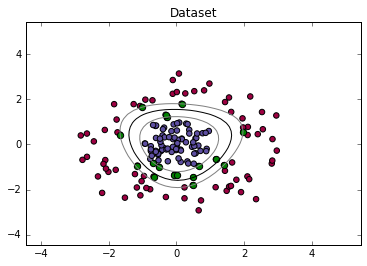

In [119]:
print "Another non-Linear dataset using polynomial kernel: "
Kernel_SVM(X2_nl,y2_nl,0.1,polynomial)

Another linear dataset using Gaussian kernel 
     pcost       dcost       gap    pres   dres
 0:  7.8078e+03 -2.1238e+05  4e+05  3e-01  6e-14
 1:  4.6681e+03 -2.5144e+04  3e+04  5e-03  8e-14
 2: -8.2214e+02 -5.8752e+03  5e+03  4e-04  7e-14
 3: -1.7852e+03 -3.6022e+03  2e+03  1e-04  7e-14
 4: -1.9734e+03 -3.1884e+03  1e+03  6e-05  8e-14
 5: -2.1349e+03 -3.1274e+03  1e+03  3e-05  7e-14
 6: -2.2876e+03 -2.8839e+03  6e+02  1e-05  8e-14
 7: -2.3625e+03 -2.7140e+03  4e+02  6e-06  8e-14
 8: -2.4377e+03 -2.5926e+03  2e+02  9e-07  1e-13
 9: -2.4663e+03 -2.5590e+03  9e+01  2e-07  1e-13
10: -2.4812e+03 -2.5300e+03  5e+01  7e-08  9e-14
11: -2.4978e+03 -2.5062e+03  8e+00  5e-14  1e-13
12: -2.5016e+03 -2.5018e+03  1e-01  2e-14  1e-13
13: -2.5017e+03 -2.5017e+03  1e-03  1e-14  1e-13
Optimal solution found.
66 support vectors out of 160 points
37 out of 40 predictions correct
Accurcy of SVM is  0.925


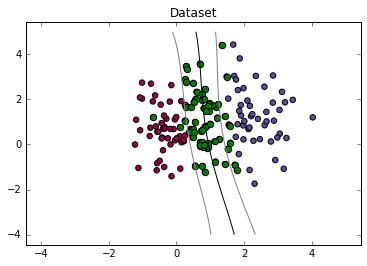

In [114]:
print "Another linear dataset using Gaussian kernel "
Kernel_SVM(X2,y2,50,gaussian)

Anonter non-Linear dataset using Gaussian kernel: 
     pcost       dcost       gap    pres   dres
 0:  1.6370e+06 -1.2046e+07  1e+07  6e-14  6e-13
 1:  5.7377e+05 -1.1602e+06  2e+06  4e-13  6e-13
 2:  1.0994e+05 -1.8537e+05  3e+05  4e-13  3e-13
 3:  1.5491e+04 -2.9104e+04  4e+04  3e-13  2e-13
 4:  5.5905e+03 -1.6417e+04  2e+04  9e-14  2e-13
 5:  2.1290e+02 -8.6442e+03  9e+03  1e-13  2e-13
 6: -7.4536e+02 -7.0832e+03  6e+03  3e-13  2e-13
 7: -1.3540e+03 -6.2336e+03  5e+03  2e-13  2e-13
 8: -2.1555e+03 -4.2720e+03  2e+03  3e-13  2e-13
 9: -2.7184e+03 -3.3477e+03  6e+02  6e-14  3e-13
10: -2.9365e+03 -3.0437e+03  1e+02  2e-13  3e-13
11: -2.9818e+03 -2.9871e+03  5e+00  7e-13  3e-13
12: -2.9842e+03 -2.9842e+03  8e-02  4e-13  3e-13
13: -2.9842e+03 -2.9842e+03  8e-04  1e-14  3e-13
Optimal solution found.
13 support vectors out of 160 points
39 out of 40 predictions correct
Accurcy of SVM is  0.975


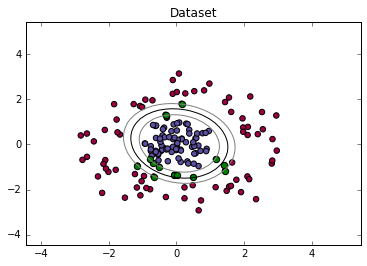

In [120]:
print "Anonter non-Linear dataset using Gaussian kernel: "
Kernel_SVM(X2_nl,y2_nl,500, gaussian)

#### I tried several Cs between [0.01 to 1000], I found that the larger C, more data would be choosen as support vectors. It may cost overfitting.

#### And I think gaussian kernel works better on linear seperable dataset.

## 6. Test what happens when one of the classes has substantially more examples. Implement and test a solution for this case

In [93]:
def lineardata_un(datasize = 200):
    # generate training data in the 2-d case
    size1 = 130
    size2 = datasize-size1
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.8, 0.6], [0.6, 0.8]])
    X1 = np.random.multivariate_normal(mean1, cov, size1)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, size2)
    y2 = np.ones(len(X2)) * -1
    X = np.append(X1, X2,axis = 0)
    y = np.append(y1,y2)
    return X,y

X3,y3 = lineardata_un()


Unbalanced linear dataset using linear kernel 
     pcost       dcost       gap    pres   dres
 0: -6.2386e+00 -2.2024e+01  6e+02  2e+01  2e-15
 1: -1.2892e+00 -1.9495e+01  4e+01  6e-01  2e-15
 2: -4.8718e-01 -4.0521e+00  4e+00  1e-02  1e-15
 3: -7.1015e-01 -1.5546e+00  9e-01  3e-03  8e-16
 4: -8.2053e-01 -1.1466e+00  3e-01  8e-04  7e-16
 5: -8.7922e-01 -9.8854e-01  1e-01  2e-04  8e-16
 6: -8.9804e-01 -9.4603e-01  5e-02  8e-05  1e-15
 7: -9.0760e-01 -9.2661e-01  2e-02  2e-05  8e-16
 8: -9.1521e-01 -9.1626e-01  1e-03  6e-07  1e-15
 9: -9.1566e-01 -9.1568e-01  2e-05  5e-09  1e-15
10: -9.1567e-01 -9.1567e-01  2e-07  5e-11  1e-15
Optimal solution found.
16 support vectors out of 160 points
39 out of 40 predictions correct
Accurcy of SVM is  0.975
Size of class 1: 130
Size of class 2: 70


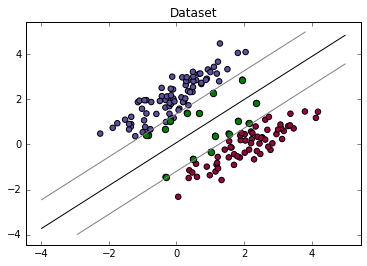

In [122]:
print "Unbalanced linear dataset using linear kernel "
Kernel_SVM(X3,y3,0.1)
print 'Size of class 1:', len(y3[y3 ==1])
print "Size of class 2:", len(y3[y3 == -1])

Unbalanced linear dataset using polynomial kernel 
     pcost       dcost       gap    pres   dres
 0:  4.4696e+00 -3.0792e+03  7e+03  3e-01  1e-12
 1:  2.0110e+01 -3.2361e+02  6e+02  2e-02  1e-12
 2:  7.6570e+00 -8.0095e+01  1e+02  4e-03  3e-13
 3:  1.8130e+00 -1.9134e+01  3e+01  7e-04  7e-14
 4:  5.0554e-01 -3.4715e+00  5e+00  8e-05  2e-14
 5: -2.1736e-03 -4.6768e-01  5e-01  3e-06  8e-15
 6: -1.9894e-01 -3.7671e-01  2e-01  1e-07  3e-15
 7: -2.5182e-01 -2.7918e-01  3e-02  1e-08  4e-15
 8: -2.6349e-01 -2.6505e-01  2e-03  2e-10  3e-15
 9: -2.6425e-01 -2.6429e-01  3e-05  2e-12  3e-15
10: -2.6427e-01 -2.6427e-01  1e-06  2e-14  3e-15
11: -2.6427e-01 -2.6427e-01  4e-08  3e-16  3e-15
Optimal solution found.
5 support vectors out of 160 points
39 out of 40 predictions correct
Accurcy of SVM is  0.975


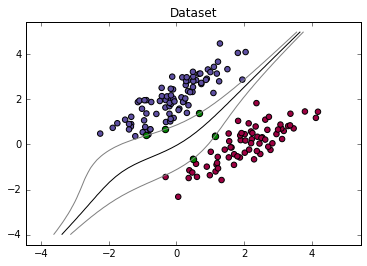

In [123]:
print "Unbalanced linear dataset using polynomial kernel "
Kernel_SVM(X3,y3,10, polynomial)


Unbalanced linear dataset using gaussian kernel 
     pcost       dcost       gap    pres   dres
 0:  3.7777e+02 -5.6424e+03  1e+04  3e-01  2e-14
 1:  2.8357e+02 -6.2352e+02  1e+03  7e-03  2e-14
 2:  2.3357e+01 -9.4797e+01  1e+02  2e-14  2e-14
 3: -2.2520e+00 -6.8181e+01  7e+01  2e-14  1e-14
 4: -1.5019e+00 -6.6105e+01  6e+01  1e-14  1e-14
 5: -1.3325e+01 -7.4025e+01  6e+01  1e-14  1e-14
 6: -2.3333e+01 -5.9551e+01  4e+01  6e-15  1e-14
 7: -2.9665e+01 -5.0670e+01  2e+01  1e-14  8e-15
 8: -3.4720e+01 -4.5798e+01  1e+01  3e-15  1e-14
 9: -3.5113e+01 -4.4309e+01  9e+00  1e-14  1e-14
10: -3.7275e+01 -4.1405e+01  4e+00  1e-14  1e-14
11: -3.8778e+01 -3.9584e+01  8e-01  1e-14  1e-14
12: -3.9154e+01 -3.9166e+01  1e-02  1e-14  1e-14
13: -3.9159e+01 -3.9160e+01  3e-04  4e-15  1e-14
14: -3.9160e+01 -3.9160e+01  6e-06  2e-14  1e-14
Optimal solution found.
9 support vectors out of 160 points
39 out of 40 predictions correct
accurcy of SVM is  0.975


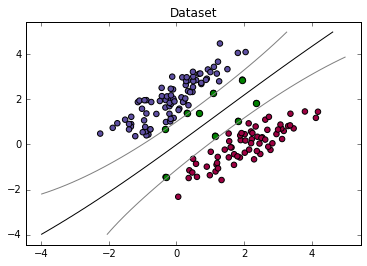

In [35]:
print "Unbalanced linear dataset using gaussian kernel "
Kernel_SVM(X3,y3,10, gaussian)


#### In this dataset, one class has 130 examples and another one has 70 examples.   
#### By comparation, I found all three kernels works well on the this dataset.